In [1]:
import pandas as pd, numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def getYearData(year):
    
    print("Opening store at... /home/data/spring_2019/outputs/model_data_output.h5")
    store = pd.HDFStore("/home/data/spring_2019/outputs/model_data_output.h5")
    
    print("Loading data from store")
    persons = store["/{}/persons".format(year)]
    hh = store["/{}/households".format(year)]
    bldg = store["/{}/buildings".format(year)]
    prcl = store["/{}/parcels".format(year)]
    
    print("Done loading data")
    store.close()
    print("Closing store. Beginning merge.")

    bldg = bldg.reset_index()[["building_id", "parcel_id"]]
    prcl = prcl.reset_index()[["parcel_id", "county_id"]]
    
    bldg = bldg.merge(prcl, on="parcel_id")
    
    hh = hh.merge(bldg, on="building_id")
    
    hh.index.name = "household_id"
    
    hh = hh.reset_index()
    
    persons.index.name = "person_id"
    persons = persons.reset_index()
    
    print("finished merging")
    
    return persons, hh

def location_quotient(unit, ref_unit, variable, category, out, year):
    
    # Step 0 - Subset the data
    
    # subset = persons[["person_id", variable, "household_id"]]\
    #.merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])
    
    print("Accessing year data")
    persons, hh = getYearData(year)
    
    print("Merging persons and household tables.")
    subset = persons[["person_id", variable, "household_id"]]\
    .merge(hh[["household_id", unit, ref_unit]], on="household_id", suffixes=["_p", "_hh"])

    
    # Step 1 - Generate and store percentages for each reference unit.
    
    ## creates a lookup table where the proportions are calculated at the county level.
    ## values can be accessed by indexing in [ref_unit, variable_i] for all i in the variable set (ie. 1 and 2 in sex)
    print("Creating lookup table for refrence geometry unit: {}".format(ref_unit))
    ref_lookup = pd.crosstab(subset[ref_unit], subset[variable]).apply(lambda r: r/r.sum(), axis=1)
    
    # -----------------------------------------------------------------------------------------------------------
    
    # Step 2 - Generate and store percentages for each local unit
    
    # this DF contains the number of people per unit being analyzed
    print("Compiling unit totals")
    unit_totals = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]].groupby(level=[0,1]).agg(sum)
    
    # this DF contains the number of people for each category of the variable being analyzed
    unit_values = subset.groupby([ref_unit,unit,variable]).agg("count")[["person_id"]]
    
    # this DF has both the total number of persons AND the number of persons per category
    print("Creating data frame with variable ({}) values at the unit ({}) level".format(variable, unit))
    compiled = unit_values.reset_index().merge(unit_totals.reset_index(), on=[ref_unit, unit],\
                                               suffixes=["_cat", "_{}".format(unit)])\
    .groupby([ref_unit, unit, variable]).agg("sum")
    
    # create a new column with the percent of persons per that category given the unit
    print("Computing unit percentages.")
    compiled["pct"] = compiled["person_id_cat"] / compiled["person_id_{}".format(unit)]
    
    # -----------------------------------------------------------------------------------------------------------
    
    # Step 3 - Associate reference unit with local unit
    print("Indexing into reference unit lookup table to compute LQs")
    dfs = []

    for i, refDF in compiled.groupby(level=0):
    # i represents the reference geometry unit (e.g. 75 for "county")
    
        for j, localDF  in refDF.groupby(level=1):
            # j represents the local geometry unit (e.g. 40100 for "tract")

            local_values = [i, j]
            cols = [ref_unit, unit]


            for k, valueDF in localDF.groupby(level=2):
                # k represents the variable category (e.g. 1 or 2 for "sex")

                # calculate location quotients by dividing proportion in unit by proportion in ref unit
                try:
                    lq = compiled.loc[i,j,k]["pct"] / ref_lookup.loc[i,k]

                # if there are no records for this particular variable category in this unit, LQ = 0
                except TypeError:

                    lq = 0

                local_values.append(lq)
                cols.append(k)

            dfs.append(pd.DataFrame([local_values], columns=cols))
    results = pd.concat(dfs, ignore_index=True)
    print("results complete")
    
    # some tracts won't have any values for a certain category. Right now, we'll treat those as 0.
    results.fillna(0, inplace=True)
    
    # reorganize the order of the columns to make intuitive sense if read in table form
    results = results[list(results.columns[-2:])+list(results.columns[:-2].sort_values())]
    
    #return ref_lookup, local_lookup
    if out == "table":
        return results
    elif out == "map":
        print("merging geo information")
        merged = tracts.merge(results, left_on=["COUNTYFP", "TRACTCE"], right_on=[ref_unit, unit])
        
        print("mapping")
        ax = merged.plot(column=2, legend=True, figsize=(20,20))
        ax.set_title("Location Quotient for {} ({}={})".format(variable, variable, category))

In [9]:
#results2010 = pd.read_csv("LQ_race_id_2010.csv")
#results2015 = pd.read_csv("LQ_race_id_2015.csv")
#results2025 = pd.read_csv("LQ_race_id_205.csv")

In [8]:
#results2010.drop("Unnamed: 0", axis=1, inplace=True)
#results2015.drop("Unnamed: 0", axis=1, inplace=True)
#results2025.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
tracts = gpd.read_file("../../../spatial-data/tl_2018_06_tract/tl_2018_06_tract.shp")

In [4]:
tracts["COUNTYFP"] = tracts["COUNTYFP"].astype(int)
tracts["TRACTCE"] = tracts["TRACTCE"].astype(int)

In [5]:
key = {
    "1": "White alone",
    "2": "Black or African American alone",
    "3": "American Indian alone",
    "4": "Alaska Native alone",
    "5": "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
    "6": "Asian alone",
    "7": "Native Hawaiian and Other Pacific Islander alone",
    "8": "Some Other Race alone",
    "9": "Two or More Races"
}

In [15]:
wah10 = location_quotient(unit="tract", ref_unit="county_id", variable="work_at_home", year="2010", category="1", out="table")

Accessing year data
Opening store at... /home/data/spring_2019/outputs/model_data_output.h5
Opening /home/data/spring_2019/outputs/model_data_output.h5 in read-only mode
Loading data from store
Done loading data
Closing store. Beginning merge.
finished merging
Merging persons and household tables.
Creating lookup table for refrence geometry unit: county_id
Compiling unit totals
Creating data frame with variable (work_at_home) values at the unit (tract) level
Computing unit percentages.
Indexing into reference unit lookup table to compute LQs


/home/simon/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



results complete


In [17]:
wah25 = location_quotient(unit="tract", ref_unit="county_id", variable="work_at_home", year="2025", category="1", out="table")



Accessing year data
Opening store at... /home/data/spring_2019/outputs/model_data_output.h5
Opening /home/data/spring_2019/outputs/model_data_output.h5 in read-only mode
Loading data from store
Done loading data
Closing store. Beginning merge.
finished merging
Merging persons and household tables.
Creating lookup table for refrence geometry unit: county_id
Compiling unit totals
Creating data frame with variable (work_at_home) values at the unit (tract) level
Computing unit percentages.
Indexing into reference unit lookup table to compute LQs


/home/simon/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



results complete


In [9]:
merged = tracts[["COUNTYFP", "TRACTCE", "geometry"]].merge((results2025.set_index(["county_id", "tract"]) - results2010.set_index(["county_id", "tract"])),\
                                                 right_index=True, left_on=["COUNTYFP", "TRACTCE"])\
#.plot(figsize=(20,10), column="2", legend=True, cmap="viridis", scheme="equal_interval")

#ax.title("sup")


(36.892975999999997, 37.484636999999999)

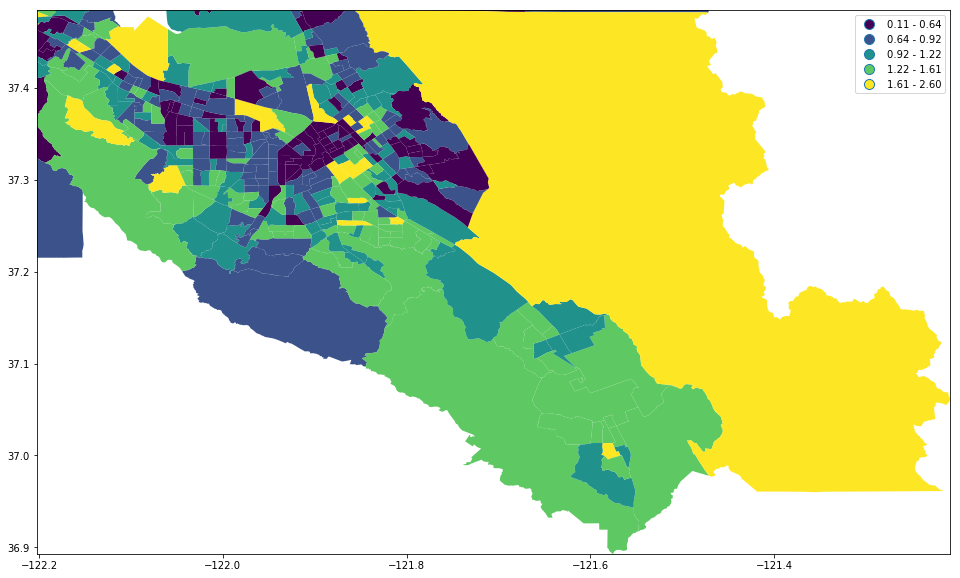

In [34]:
ax = tracts[["COUNTYFP", "TRACTCE", "geometry"]]\
.merge(results2010.set_index(["county_id", "tract"]), right_index=True, left_on=["COUNTYFP", "TRACTCE"])\
.plot(column="6", figsize=(20,10), legend=True, scheme="fisher_jenks")
            

bbox = tracts[tracts["COUNTYFP"] == 85]["geometry"].total_bounds

ax.set_xlim([bbox[0], bbox[2]])
ax.set_ylim([bbox[1], bbox[3]])


In [8]:
intervalsOfImportance = [-0.1, 0, 1, 2,3,4,5,999]
labels = ["0", "0-1", "1-2", "2-3", "3-4", "4-5", "5+"]

(36.892975999999997, 37.484636999999999)

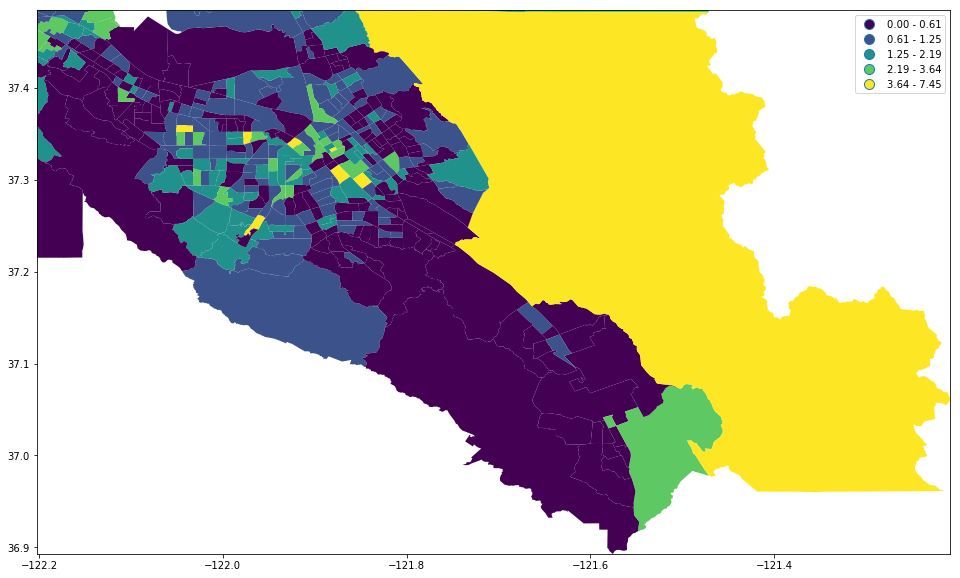

In [50]:

ax = tracts[["COUNTYFP", "TRACTCE", "geometry"]]\
.merge(results2015.set_index(["county_id", "tract"]), right_index=True, left_on=["COUNTYFP", "TRACTCE"])\
.plot(column="3", figsize=(20,10), legend=True, scheme="fisher_jenks")
            
    
bbox = tracts[tracts["COUNTYFP"] == 85]["geometry"].total_bounds

ax.set_xlim([bbox[0], bbox[2]])
ax.set_ylim([bbox[1], bbox[3]])


In [6]:
key

{'1': 'White alone',
 '2': 'Black or African American alone',
 '3': 'American Indian alone',
 '4': 'Alaska Native alone',
 '5': 'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races',
 '6': 'Asian alone',
 '7': 'Native Hawaiian and Other Pacific Islander alone',
 '8': 'Some Other Race alone',
 '9': 'Two or More Races'}

YEAR 1
Accessing year data
Opening store at... /home/data/spring_2019/outputs/model_data_output.h5
Opening /home/data/spring_2019/outputs/model_data_output.h5 in read-only mode
Loading data from store
Done loading data
Closing store. Beginning merge.
finished merging
Merging persons and household tables.
Creating lookup table for refrence geometry unit: county_id
Compiling unit totals
Creating data frame with variable (race_id) values at the unit (tract) level
Computing unit percentages.
Indexing into reference unit lookup table to compute LQs


/home/simon/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:106: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



results complete
YEAR 2
Accessing year data
Opening store at... /home/data/spring_2019/outputs/model_data_output.h5
Opening /home/data/spring_2019/outputs/model_data_output.h5 in read-only mode
Loading data from store
Done loading data
Closing store. Beginning merge.
finished merging
Merging persons and household tables.
Creating lookup table for refrence geometry unit: county_id
Compiling unit totals
Creating data frame with variable (race_id) values at the unit (tract) level
Computing unit percentages.
Indexing into reference unit lookup table to compute LQs
results complete


(37.454186, 37.905823999999996)

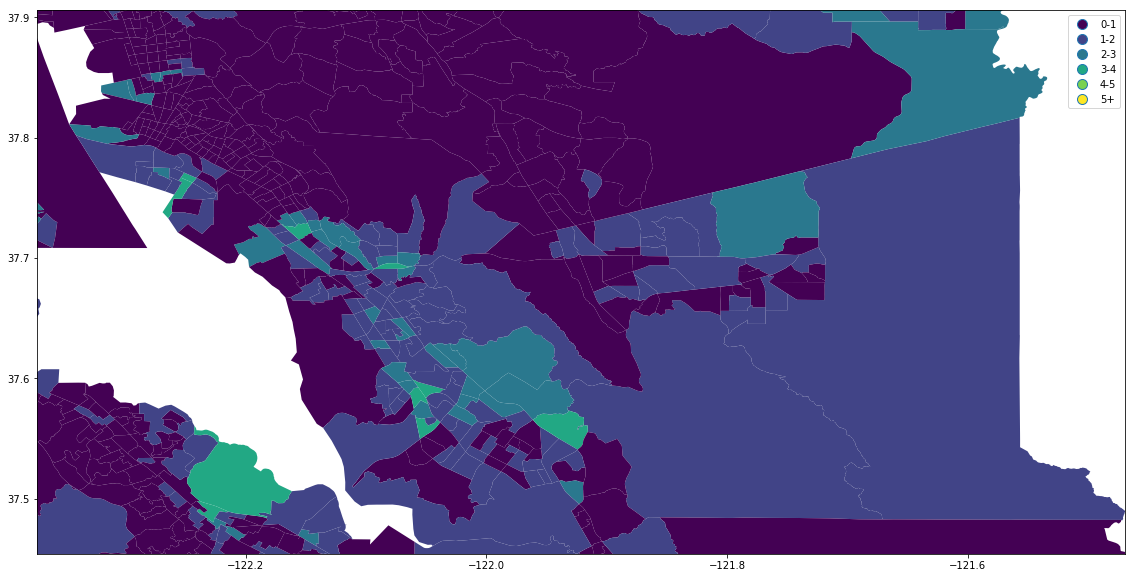

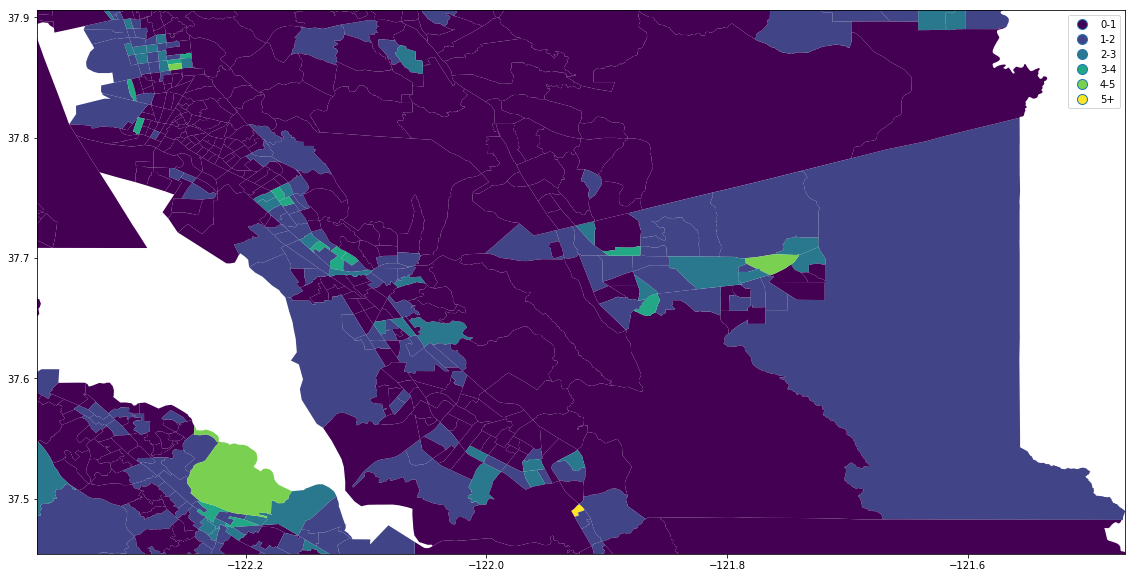

In [10]:
#yr1.drop("{}_bin".format(toBin), axis=1, inplace=True)
#yr2.drop("{}_bin".format(toBin), axis=1, inplace=True)

print("YEAR 1")
yr1 = location_quotient(unit="tract", ref_unit="county_id", variable="race_id", year="2010", category="2", out="table")
print("YEAR 2")
yr2 = location_quotient(unit="tract", ref_unit="county_id", variable="race_id", year="2025", category="2", out="table")

yr1["county_id"] = yr1["county_id"].astype(int)
yr2["county_id"] = yr2["county_id"].astype(int)
yr1["tract"] = yr1["tract"].astype(int)
yr2["tract"] = yr2["tract"].astype(int)


toBin = 2 # variable value
cty = 1

try:
    yr1["{}_bin".format(toBin)] = pd.cut(yr1["{}".format(toBin)],intervalsOfImportance, right=False, labels=labels)
except KeyError:
    yr1["{}_bin".format(toBin)] = pd.cut(yr1[toBin],intervalsOfImportance, right=False, labels=labels)

ax = tracts[["COUNTYFP", "TRACTCE", "geometry"]]\
.merge(yr1.set_index(["county_id", "tract"]), right_index=True, left_on=["COUNTYFP", "TRACTCE"])\
.plot(column="{}_bin".format(toBin), figsize=(20,10), legend=True, cmap="viridis")

bbox = tracts[tracts["COUNTYFP"] == cty]["geometry"].total_bounds

ax.set_xlim([bbox[0], bbox[2]])
ax.set_ylim([bbox[1], bbox[3]])

# comparison year

try:
    yr2["{}_bin".format(toBin)] = pd.cut(yr2["{}".format(toBin)],intervalsOfImportance, right=False, labels=labels)
except KeyError:
    yr2["{}_bin".format(toBin)] = pd.cut(yr2[toBin],intervalsOfImportance, right=False, labels=labels)


ax = tracts[["COUNTYFP", "TRACTCE", "geometry"]]\
.merge(yr2.set_index(["county_id", "tract"]), right_index=True, left_on=["COUNTYFP", "TRACTCE"])\
.plot(column="{}_bin".format(toBin), figsize=(20,10), legend=True, cmap="viridis")

bbox = tracts[tracts["COUNTYFP"] == cty]["geometry"].total_bounds

ax.set_xlim([bbox[0], bbox[2]])
ax.set_ylim([bbox[1], bbox[3]])

In [11]:
combined = yr2[yr2.columns[:-1]].set_index(["county_id", "tract"]) - yr1[yr1.columns[:-1]].set_index(["county_id", "tract"])

combined.reset_index(inplace=True)



In [12]:
comparativeInterval = [-41, -5, -2, -0.325311, 0, 1, 3, 25]
#comparativeLabels = 

In [47]:
combined[2].describe()

count    12947.000000
mean        -0.061999
std          2.867732
min        -40.585837
25%         -0.325311
50%          0.000000
75%          0.903753
max         24.707776
Name: 2, dtype: float64

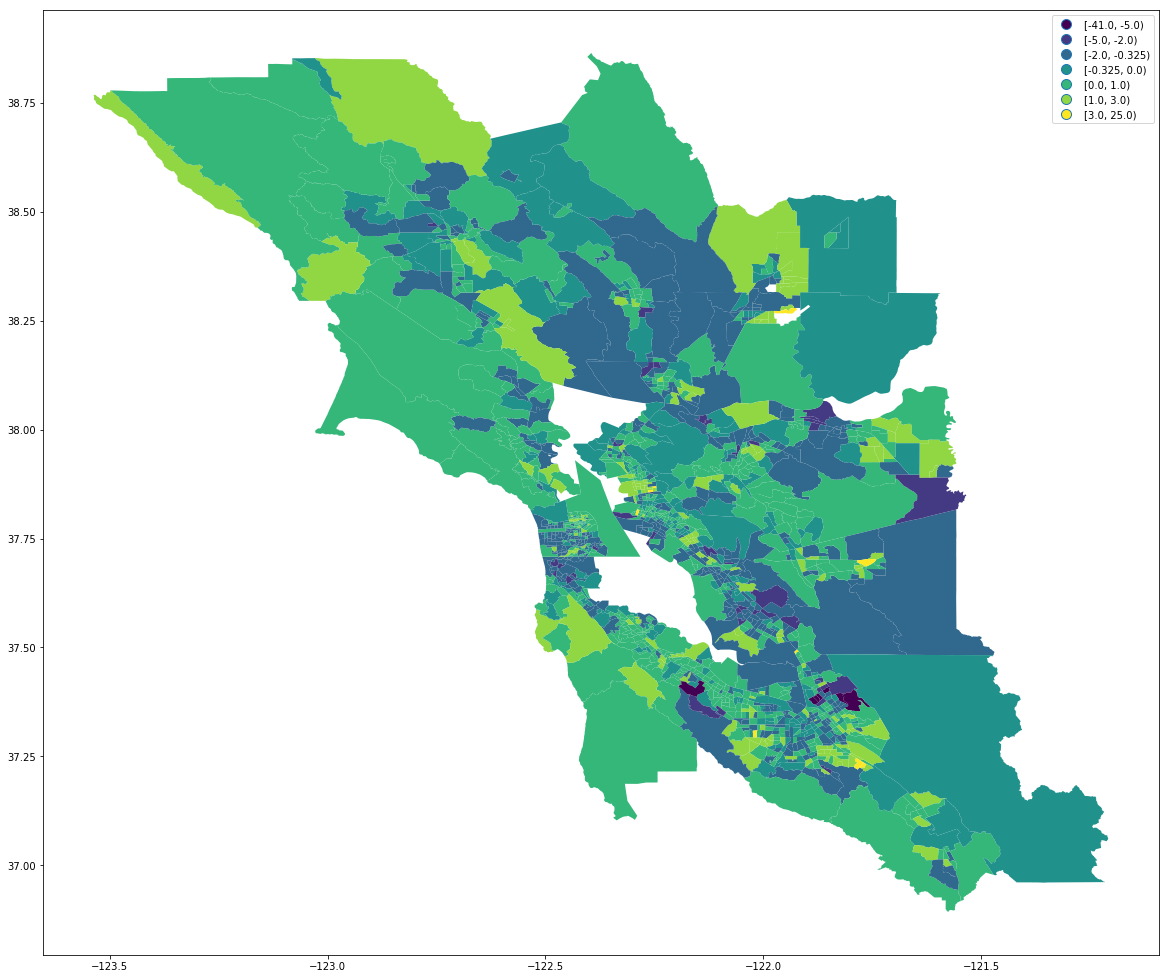

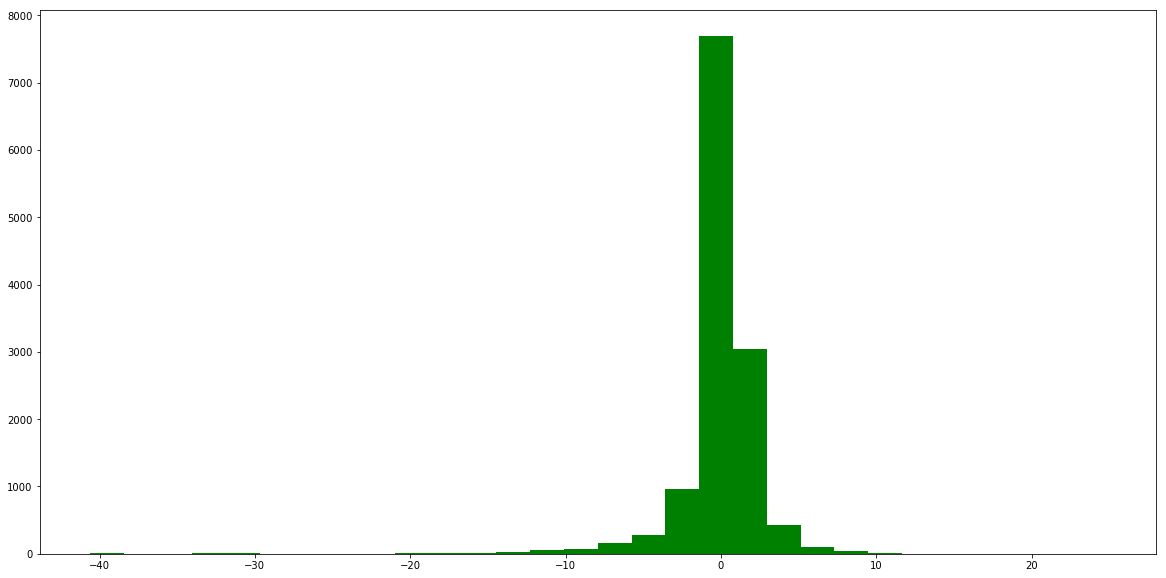

In [22]:
toBin = 2 # variable value
cty = 0

try:
    combined["{}_bin".format(toBin)] = pd.cut(combined["{}".format(toBin)],comparativeInterval, right=False, )
except KeyError:
    combined["{}_bin".format(toBin)] = pd.cut(combined[toBin],comparativeInterval, right=False)

ax = tracts[["COUNTYFP", "TRACTCE", "geometry"]]\
.merge(combined.set_index(["county_id", "tract"]), right_index=True, left_on=["COUNTYFP", "TRACTCE"])\
.plot(column="{}_bin".format(toBin), figsize=(20,20), legend=True, cmap="viridis")

if cty != 0:
    bbox = tracts[tracts["COUNTYFP"] == cty]["geometry"].total_bounds

    ax.set_xlim([bbox[0], bbox[2]])
    ax.set_ylim([bbox[1], bbox[3]])
    
else:
    pass


plt.figure(figsize=(20,10))

if cty != 0:
    plt.hist(combined[combined["county_id"] == cty][toBin].dropna(), bins=30, color="green")
else:
    plt.hist(combined[toBin].dropna(), bins=30, color="green")

plt.show()

Comparing the differences between location quotients from year to another allows us to observe the extent to which the concentration of a certain variable within a certain geometry. When the difference between location quotients calculcated in different years.

In [31]:
tracts[tracts["COUNTYFP"].isin(["001", "013", "041", "055", "075", "081", "085", "095", "097"])].shape

(1588, 13)

In [32]:
1588*9

14292

In [26]:
len(combined)

14107

In [33]:
combined.columns

Index([u'county_id', u'tract', 1, 2, 3, 4, 5, 6, 7, 8, 9, u'2_bin'], dtype='object')

In [34]:
combined["county_id"].value_counts()

85    1577
1     1577
75    1575
13    1573
81    1571
95    1570
97    1569
41    1556
55    1539
Name: county_id, dtype: int64

In [39]:
sum(tracts["COUNTYFP"].value_counts()[[1, 13, 41, 55, 75, 81, 85, 95, 97]])

1588

In [25]:
combined[2].sort_values()

14106   -40.585837
13610   -40.585837
13888   -40.585837
12611   -40.585837
13101   -40.585837
14050   -38.207624
12469   -33.977325
11691   -33.977325
11466   -33.977325
11178   -32.866575
11690   -32.849745
11574   -32.205414
12684   -31.267154
3299    -30.660980
3171    -30.660980
3278    -30.660980
4009    -30.660980
3654    -30.660980
4036    -30.660980
3284    -30.660980
3851    -30.660980
4261    -30.660980
9591    -29.520650
12518   -27.775635
12258   -27.570235
10335   -27.067483
12895   -27.057225
13427   -27.057225
3808    -26.859784
11761   -24.674790
           ...    
13687          NaN
13694          NaN
13775          NaN
13788          NaN
13794          NaN
13796          NaN
13806          NaN
13809          NaN
13811          NaN
13829          NaN
13839          NaN
13862          NaN
13867          NaN
13882          NaN
13915          NaN
13929          NaN
13947          NaN
13950          NaN
13957          NaN
13995          NaN
14003          NaN
14016       